In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
from scipy.integrate import odeint, solve_ivp
import random
import time
import torch.utils.data as data


def func(t, m,h,gamma,alpha):
     dm=-gamma*(np.cross(m,h)-alpha*np.cross(m,-gamma*np.cross(m,h)))
     
     return dm
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



class simple_NN(nn.Module): #define neural network
    def __init__(self):
        super(simple_NN, self).__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 3),nn.Tanh()
        )

    def forward(self, x):
        out = self.linear_tanh_stack(x)
        return out



def df(f: simple_NN, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = torch.tensor([]).to(device)
    df_value.requires_grad = True
    # torch.reshape(df_value,([20,1]))
    for i in range(3):
        df_value=torch.cat( (df_value,torch.autograd.grad(
            f(x)[:,i].reshape(len(x),1),
            x,
            grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]),1)

    return df_value



#define loss function for PINN
def compute_loss(p,nn: simple_NN, 
                 t: torch.Tensor = None, 
                 t_train: torch.Tensor = None,
                 m_train: torch.Tensor = None, domain=[0.,30.]
                 ) -> torch.float:
    """Compute the full loss function as pde loss + boundary loss + norm_loss +mse_loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    (h_,gamma,alpha)=p
    h=torch.cat((torch.ones(len(t),1)*h_[0],torch.ones(len(t),1)*h_[1],torch.ones(len(t),1)*h_[2]),1).to(device)
    m=nn(t)
    pde_loss=torch.nn.MSELoss()(df(nn,t)+gamma*(torch.linalg.cross(m,h)-alpha*torch.linalg.cross(m,-gamma*torch.linalg.cross(m,h))),torch.zeros(len(t),3).to(device))
    norm_loss=torch.nn.MSELoss()((torch.linalg.norm(m,axis=1)).reshape(-1, 1),torch.ones_like(t))
    
    boundary1 = torch.Tensor([[domain[0]]]).to(device)
    boundary2=torch.Tensor([[domain[-1]]]).to(device)

    m_boundary1=torch.tensor([0.0,np.sin((1/180)*np.pi),np.cos((1/180)*np.pi)]).to(device)
    m_boundary2=torch.tensor([0.0,0.,-1.]).to(device)
    
    bc_loss = ((nn(boundary1)[0] - m_boundary1).pow(2).mean()+((nn(boundary2)[0] - m_boundary2).pow(2).mean())).to(device)
    
    mse_loss = torch.nn.MSELoss()(nn(t_train), m_train)

    tot_loss = pde_loss + mse_loss+ norm_loss +bc_loss
    
    return tot_loss


#define error of model ouptut wrt numerical solution
def error(model,t_,result_odeint):
    model.eval()
    with torch.no_grad():
        t_=torch.from_numpy(np.float32(t_)).reshape(-1, 1).to(device)
        f_eval = (model(t_)).to('cpu')
        f_eval=f_eval.detach().numpy()
        err=(np.mean(np.linalg.norm(result_odeint-f_eval,axis=1)**2))**(0.5)
    return err
    

In [2]:
#plotting of model output and training data
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
def plot(model,train_t,train_m,domain):
    model.eval()
    with torch.no_grad():
        t_eval = torch.linspace(domain[0], domain[1], steps=1000).reshape(-1, 1)
        f_eval = (model(t_eval.to(device))).to('cpu')
        # plotting
        train_t1=train_t.cpu().detach().numpy()
        train_m1=train_m.cpu().detach().numpy()
        
        #2D plot of mx,my,mz vs time
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
        ax.scatter(train_t1, train_m1[:,0], label="Training data", color="#1f77b4")
        ax.plot(t_eval.detach().numpy(), f_eval.detach()[:,0].numpy(), label="NN approximation", color="#1f77b4")
        
        ax.scatter(train_t1, train_m1[:,1], label="Training data", color="#ff7f0e")
        ax.plot(t_eval.detach().numpy(), f_eval.detach()[:,1].numpy(), label="NN approximation", color="#ff7f0e")
        
        ax.scatter(train_t1, train_m1[:,2], label="Training data", color="#2ca02c")
        ax.plot(t_eval.detach().numpy(), f_eval.detach()[:,2].numpy(), label="NN approximation", color="#2ca02c")
        
        ax.set(title="Neural Network Regression", xlabel="x", ylabel="y")
        ax.legend()
        plt.show()
        
        #3D plot of (mx,my,mz)
        figure = plt.figure(figsize=(8, 8))
        bx = figure.add_subplot(2, 1, 2, projection='3d')
        bx.scatter(train_m1[:, 0],
                train_m1[:, 1],
                train_m1[:, 2], color="#1f77b4")
        bx.plot(f_eval.detach().numpy()[:,0],
                   f_eval.detach().numpy()[:,1],
                   f_eval.detach().numpy()[:,2], color="#1f77b4")
        bx.set_title("Magnetisation for 0D single spin")
        plt.show()

In [3]:
#prints number of layers and trainable parameters in the model
def model_capacity(model):
    number_of_learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_layers = len(list(model.parameters()))
    print("\n\nThe number of layers in the model: %d" % num_layers)
    print("\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)  

In [5]:
#training the model
from torch.utils.data.dataloader import default_collate
def train(p,domain,m0,num_iter:int=2000,num_train:int=20,num_coll:int=200):
    time0=time.time()
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    t_=np.linspace(domain[0],domain[1],num=1000)
    (h_,gamma,alpha)=p
    #generating training data for given parameters p 
    result_odeint = odeint(func, m0, t_,p, tfirst=True)
    train_m=[]
    train_t=[]
    # train_list=random.sample(range(1000),num_train)
    train_list=np.linspace(0,1000,num=num_train+2)[1:-1].astype(int)
    for i in train_list:
        train_m.append(result_odeint[i])
        train_t.append([t_[i]])
    
    train_m=torch.tensor(np.array(train_m), dtype=torch.float32,requires_grad=True).to(device)
    train_t=torch.tensor(np.array(train_t), dtype=torch.float32,requires_grad=True).to(device)
    t=torch.sort(domain[-1]*torch.rand(num_coll,dtype=torch.float32))[0].reshape(-1, 1).to(device)
    t.requires_grad=True


    #initializing the model
    model=simple_NN()
    model=model.to(device)
    #printing parameters
    model_capacity(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_list=[]
    # Train
    for ep in range(num_iter):
        model.train()
        optimizer.zero_grad()
        loss = compute_loss(p,model, t, train_t, train_m,domain)
        loss.backward()
        optimizer.step()
        if loss<0.00001:
            break
        model.eval()
        with torch.no_grad():
            loss_list.append(loss.cpu().detach().numpy())
        if ep % 500 == 0:
            print(f"epoch: {ep}, loss: {loss.item():>7f}")
    print(f"final loss: {loss.item():>7f}")
    print("RMS Error is:",error(model,t_,result_odeint))
    time1=time.time()
    print("Time taken:",(int((time1-time0)*100))/100,"s")
    plot(model,train_t,train_m,domain)
    
    return (model, np.array(loss_list))



The number of layers in the model: 10

The number of learnable parameters in the model: 2211
epoch: 0, loss: 1.540834
epoch: 500, loss: 0.055200
epoch: 1000, loss: 0.016162
epoch: 1500, loss: 0.008865
epoch: 2000, loss: 0.004983
epoch: 2500, loss: 0.009353
epoch: 3000, loss: 0.003344
epoch: 3500, loss: 0.004551
epoch: 4000, loss: 0.003921
epoch: 4500, loss: 0.003449
final loss: 0.003340
RMS Error is: 0.08450873488286816
Time taken: 127.8 s


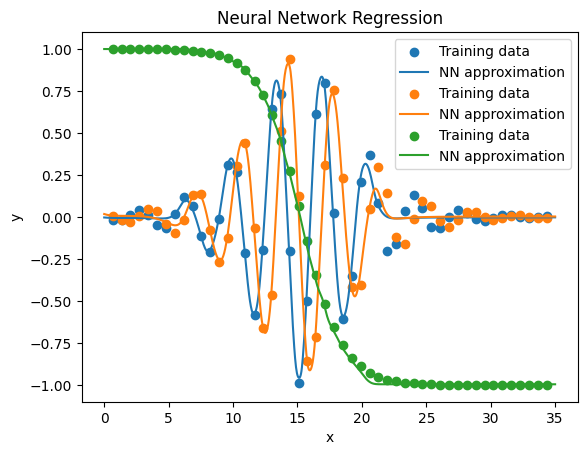

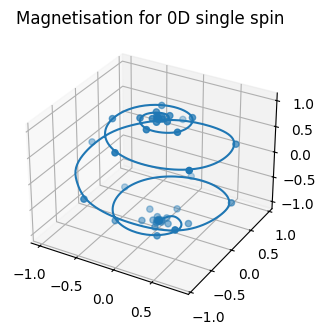

In [7]:
#specify:(H_ext,gamma,alpha)
p=((0, 0, -1), -1.76, 0.10)
#train(p,domain,m_initial,number of epochs,number of training points, number of collocation points)
model=train(p,[0.,35.],[0,np.sin((1/180)*np.pi),np.cos((1/180)*np.pi)],5000,50,700)

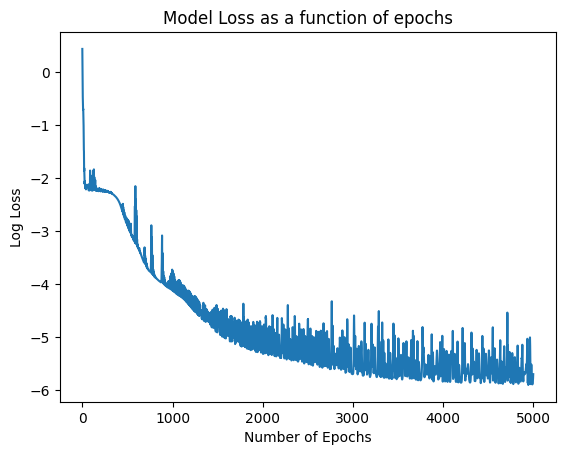

In [11]:
plt.plot(np.log(model[1]))
plt.xlabel("Number of Epochs")
plt.ylabel("Log Loss")
plt.title("Model Loss as a function of epochs")
plt.show()